# Dataset Exploration

---
In this notebook, we explore the in put data file and the different datasets contained in it
- A set of physics-motivated high-level features
- Jets represented as an image
- Jets represented as a list of particles
These different representations will be used to train different kind of networks while solving the same problem,
a classification task aiming to distinguish jets originating from quarks, gluons, Ws, Zs, or top quarks.

---

We start loading the main libraries
- h5py to read the input HDF5 file
- numpy top handle the datasets stored there
- matplotlib for graphs
---

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Reading the data

---
In order to import the dataset, we now
- load the h5 files in the data/ repository
- extract the data we need: a target and jetImage

This last line is there to tell matplotlib to open the graphs inside the jupyter notebook

In [2]:
# let's open the file
fileIN = 'jetImage_7_100p_0_10000.h5'
f = h5py.File(fileIN)
# and see what it contains
print(list(f.keys()))

['jetConstituentList', 'jetFeatureNames', 'jetImage', 'jetImageECAL', 'jetImageHCAL', 'jets', 'particleFeatureNames']


---
- 'jetImage' contains the image representation of the jets (more later)
- 'jetImageECAL' and 'jetImageHCAL' are the ECAL- and HCAL-only equivalent images. We will not use them (but you are more than welcome to play with it)
- 'jetConstituentList' is the list of particles cointained in the jet. For each particle, a list of relevant quantities is stored
- 'particleFeatureNames' is the list of the names corresponding to the quantities contained in 'jetConstituentList'
- 'jets' is the dataset we consider for the moment
- 'jetFeatureNames' is the list of the names corresponding to the quantities contained in 'jets'

The first 100 highest-$p_T$ particles are considered for each jet

---

## The physics-motivated high-level features

We then open the input file and load the 'jet' data, containing
- the discriminating quantities
- the truth (which kind of jet we are dealing with)

In [3]:
# These are the quantities we are dealing with
featurenames = f.get('jetFeatureNames')
print(featurenames[:])
# the b is due to the byte vs utf-8 encoding of the strings in the dataset
# just ignore them for the moment

[b'j_ptfrac' b'j_pt' b'j_eta' b'j_mass' b'j_tau1_b1' b'j_tau2_b1'
 b'j_tau3_b1' b'j_tau1_b2' b'j_tau2_b2' b'j_tau3_b2' b'j_tau32_b1'
 b'j_tau32_b2' b'j_zlogz' b'j_c1_b0' b'j_c1_b1' b'j_c1_b2' b'j_c2_b1'
 b'j_c2_b2' b'j_d2_b1' b'j_d2_b2' b'j_d2_a1_b1' b'j_d2_a1_b2' b'j_m2_b1'
 b'j_m2_b2' b'j_n2_b1' b'j_n2_b2' b'j_tau1_b1_mmdt' b'j_tau2_b1_mmdt'
 b'j_tau3_b1_mmdt' b'j_tau1_b2_mmdt' b'j_tau2_b2_mmdt' b'j_tau3_b2_mmdt'
 b'j_tau32_b1_mmdt' b'j_tau32_b2_mmdt' b'j_c1_b0_mmdt' b'j_c1_b1_mmdt'
 b'j_c1_b2_mmdt' b'j_c2_b1_mmdt' b'j_c2_b2_mmdt' b'j_d2_b1_mmdt'
 b'j_d2_b2_mmdt' b'j_d2_a1_b1_mmdt' b'j_d2_a1_b2_mmdt' b'j_m2_b1_mmdt'
 b'j_m2_b2_mmdt' b'j_n2_b1_mmdt' b'j_n2_b2_mmdt' b'j_mass_trim'
 b'j_mass_mmdt' b'j_mass_prun' b'j_mass_sdb2' b'j_mass_sdm1'
 b'j_multiplicity' b'j_g' b'j_q' b'j_w' b'j_z' b'j_t' b'j_undef']


---
The ground truth is incorporated in the ['j_g', 'j_q', 'j_w', 'j_z', 'j_t] vector of boolean, taking the form
- [1, 0, 0, 0, 0] for gluons
- [0, 1, 0, 0, 0] for quarks
- [0, 0, 1, 0, 0] for Ws
- [0, 0, 0, 1, 0] for Zs
- [0, 0, 0, 0, 1] for tops

This is what is called 'one-hot' encoding of a descrete label (typical of ground truth for classification problems)

We define the 'target' of our problem the set of these labels

In [4]:
jet_data = np.array(f.get('jets'))
target = jet_data[:,-6:-1]
# shape of the dataset
print("Dataset shape:")
print(target.shape)
print("First five entries:")
for i in range(5):
    print(target[i])
print("Last 5 entries:")
for i in range(-5,0):
    print(target[i])

Dataset shape:
(10000, 5)
First five entries:
[1. 0. 0. 0. 0.]
[0. 0. 1. 0. 0.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 1. 0. 0.]
Last 5 entries:
[0. 0. 0. 0. 1.]
[0. 0. 1. 0. 0.]
[0. 0. 0. 0. 1.]
[0. 1. 0. 0. 0.]
[0. 0. 0. 0. 1.]


As you can see there are 10K examples in this file. We will need more for a meaningful training (more later)

---

In [5]:
print(jet_data[1,-6])

0.0


And now the feature dataset

In [6]:
data = np.array(jet_data[:,:-6])
print(data.shape)

(10000, 53)


We have 53 features for each of the 66K jets
We now make some plot
---

In [7]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False

labelCat= ["gluon", "quark", "W", "Z", "top"]
# this function makes the histogram of a given quantity for the five classes
def makePlot(feature_index, input_data, input_featurenames):
    plt.subplots()
    for i in range(len(labelCat)):
        # notice the use of numpy masking to select specific classes of jets
        my_data = input_data[np.argmax(target, axis=1) == i]
        # then plot the right quantity for the reduced array
        plt.hist(my_data[:,feature_index], 50, density=True, histtype='step', fill=False, linewidth=1.5)
    plt.yscale('log')
    plt.legend(labelCat, fontsize=12, frameon=False)
    plt.xlabel(str(input_featurenames[feature_index], "utf-8"), fontsize=15)
    plt.ylabel('Prob. Density (a.u.)', fontsize=15)
    plt.show()
    #del fig, ax
    #return fig, ax

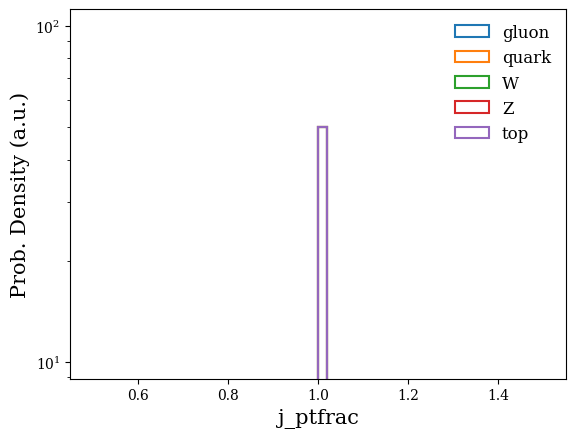

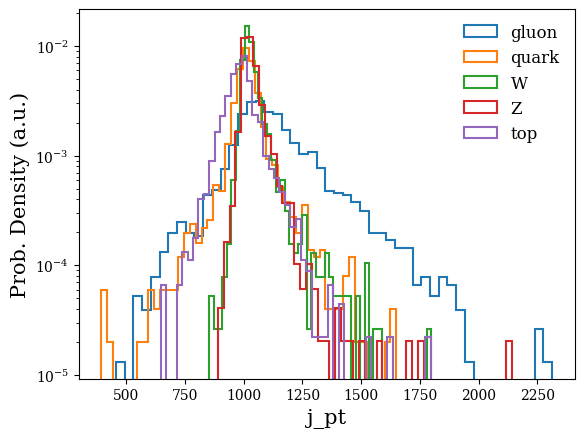

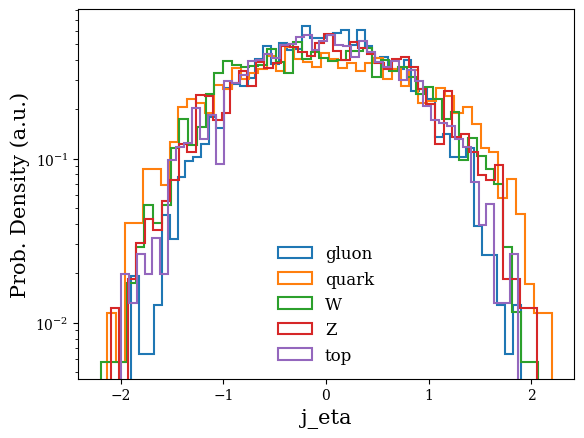

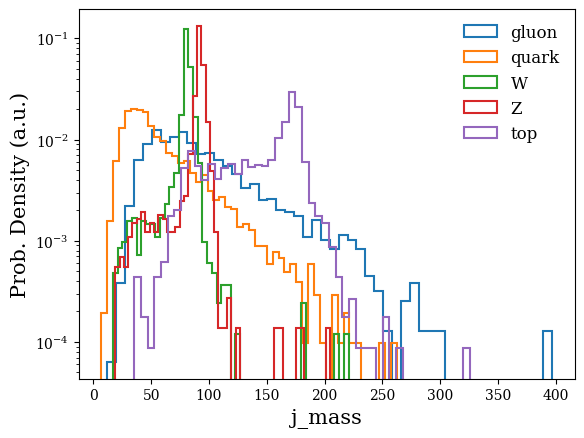

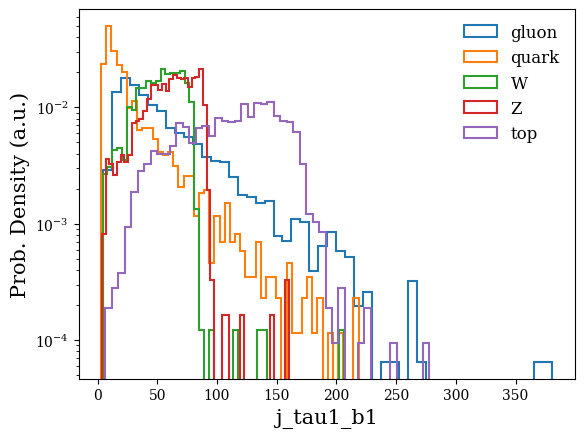

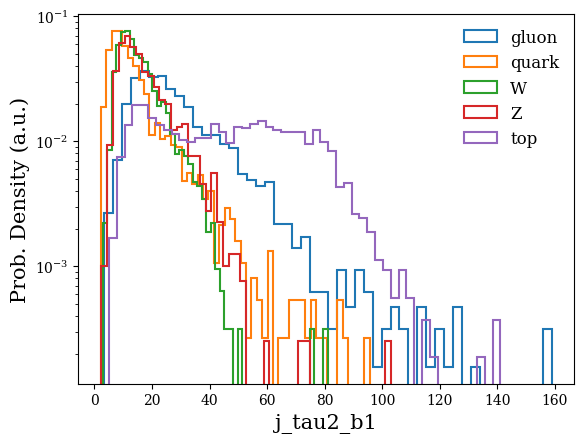

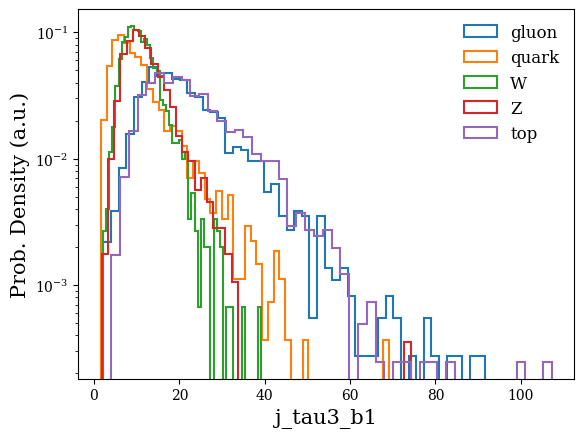

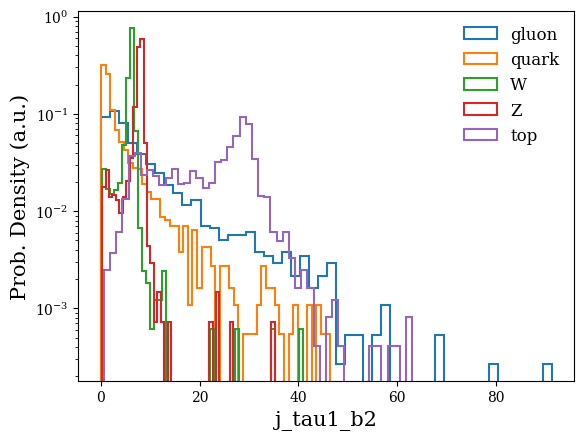

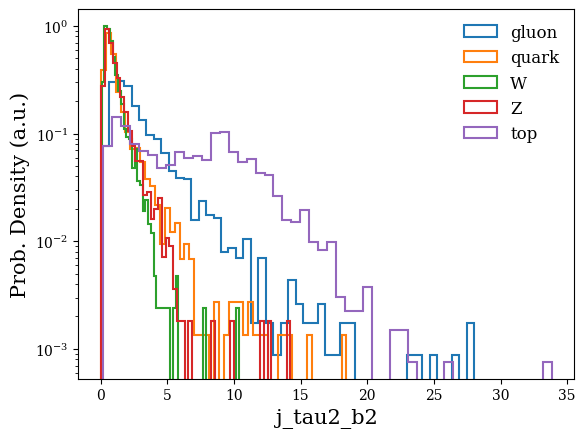

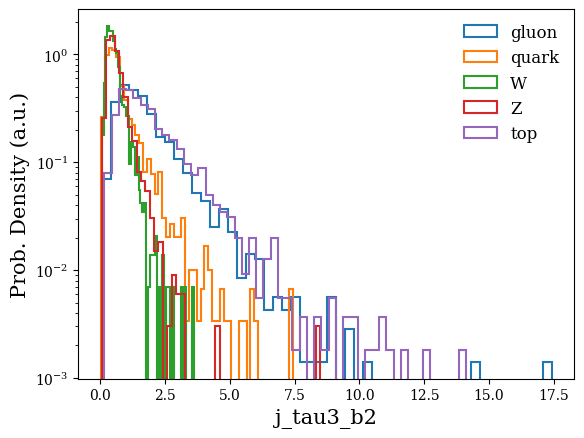

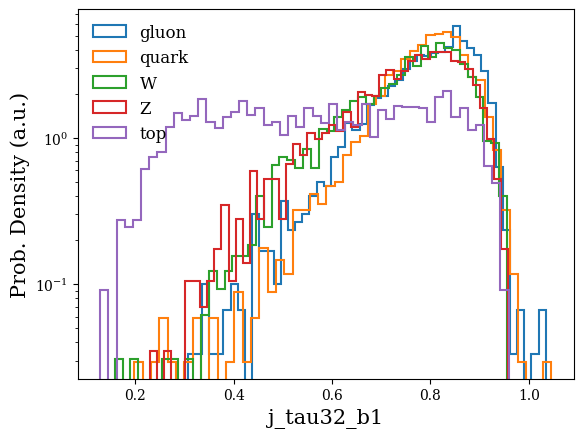

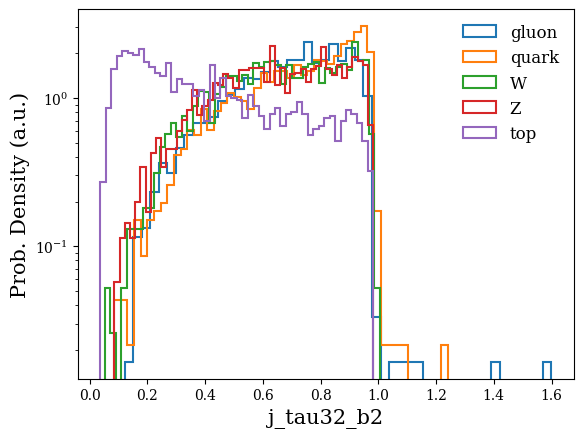

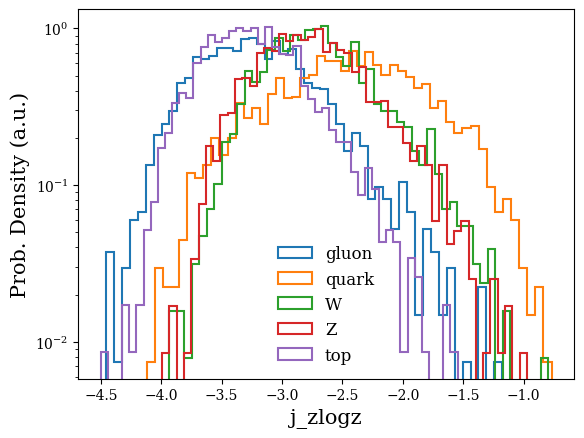

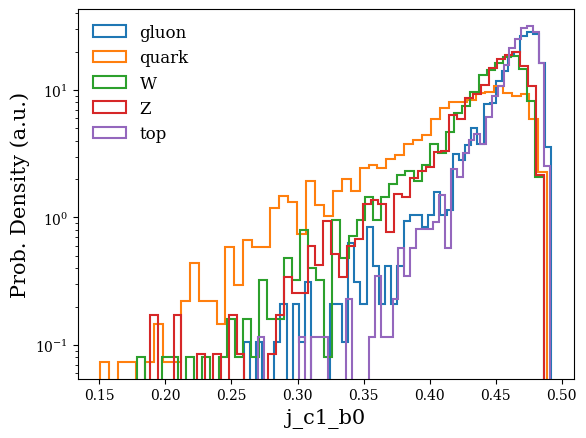

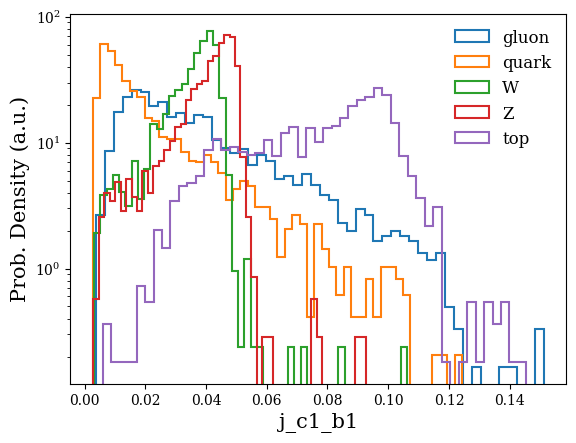

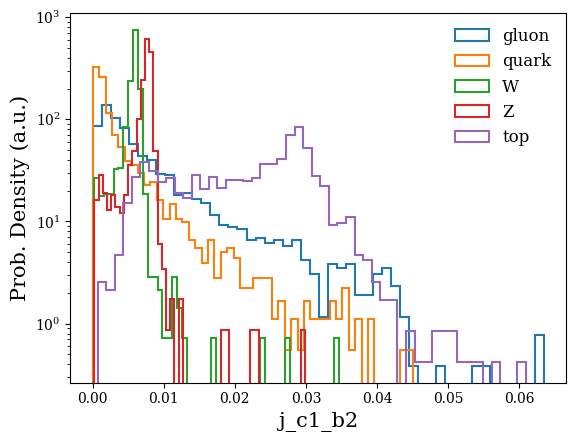

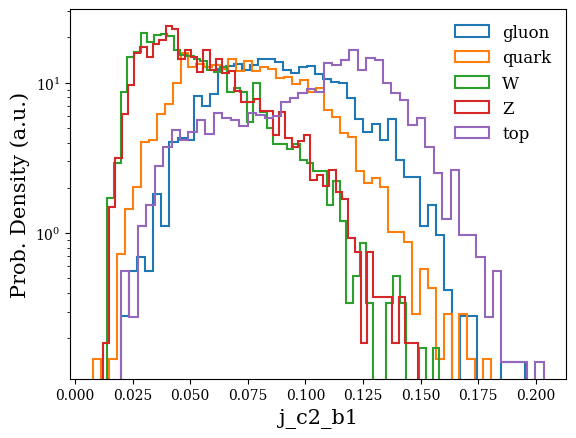

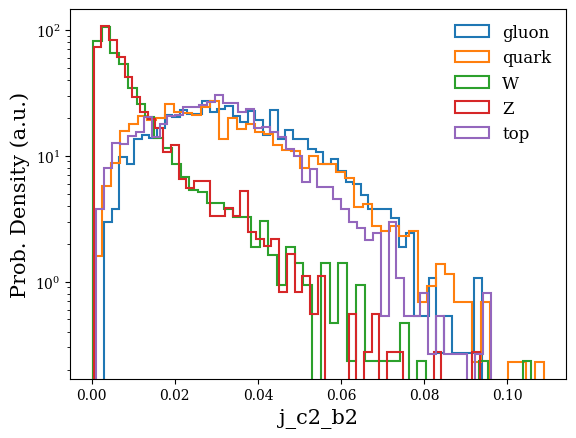

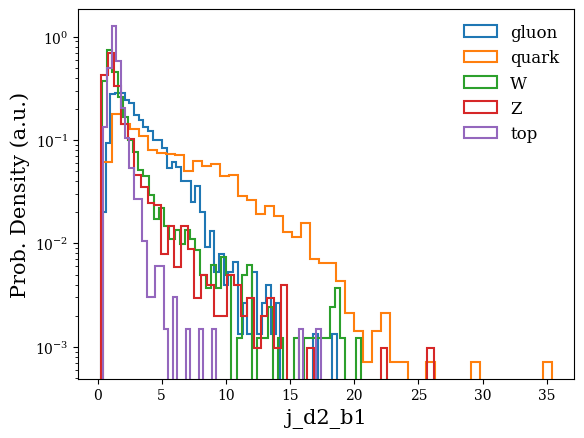

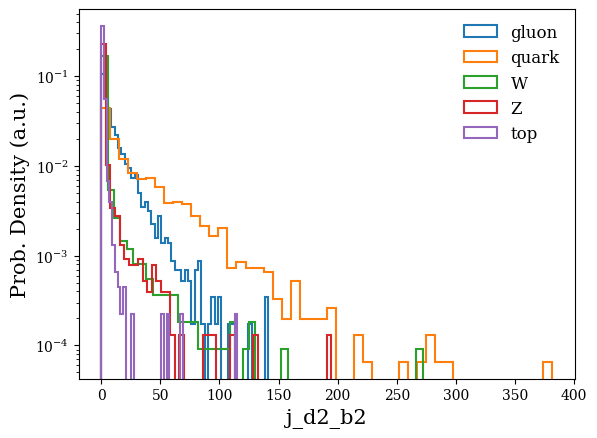

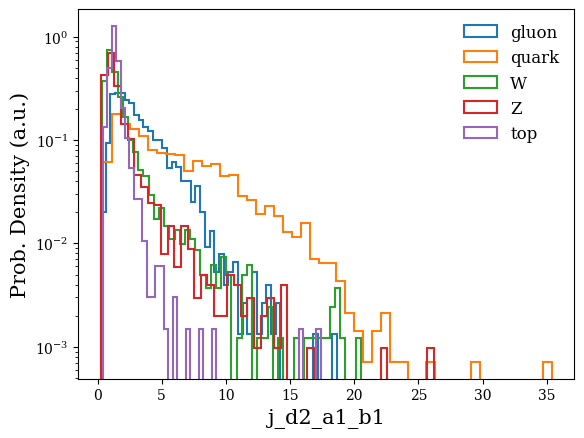

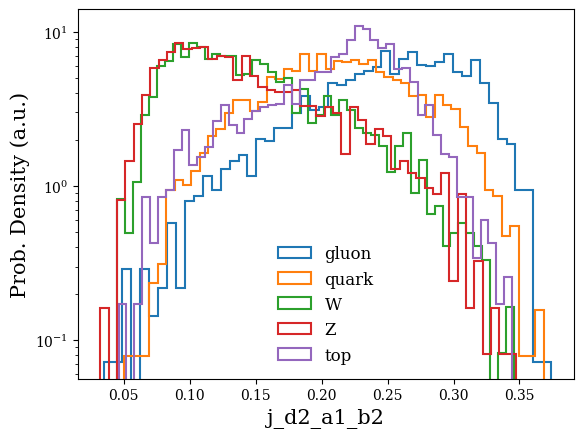

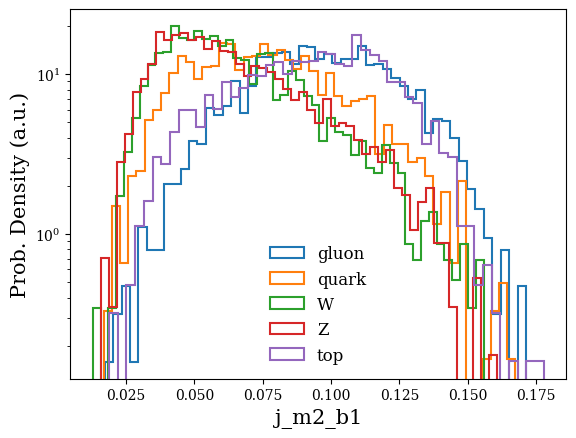

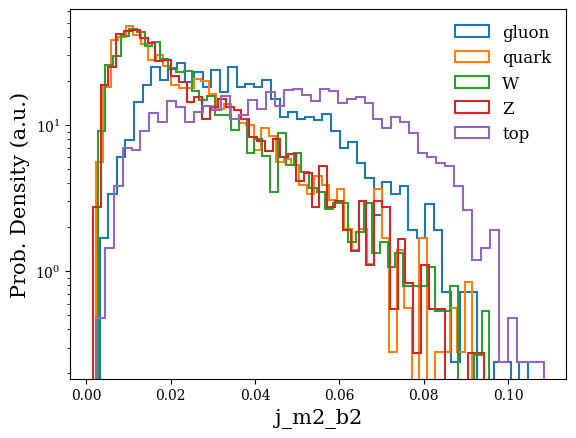

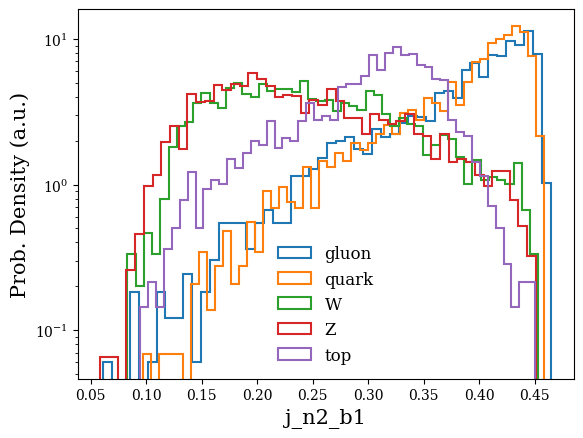

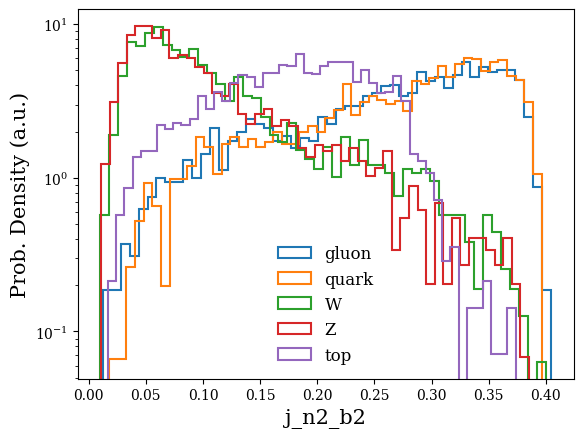

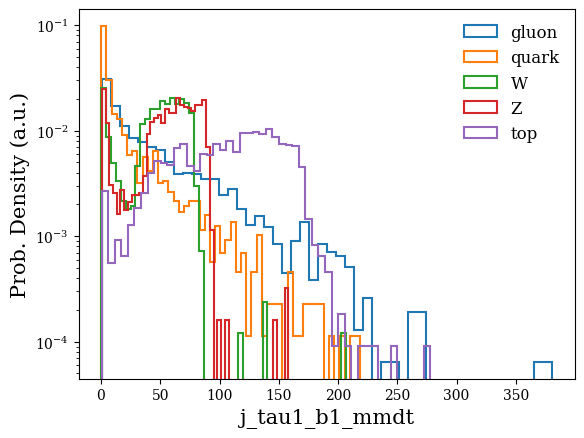

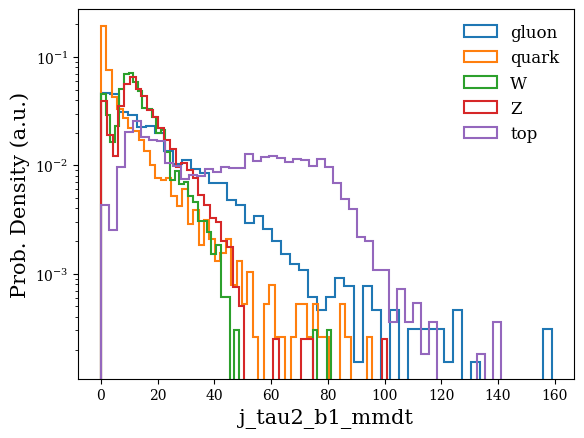

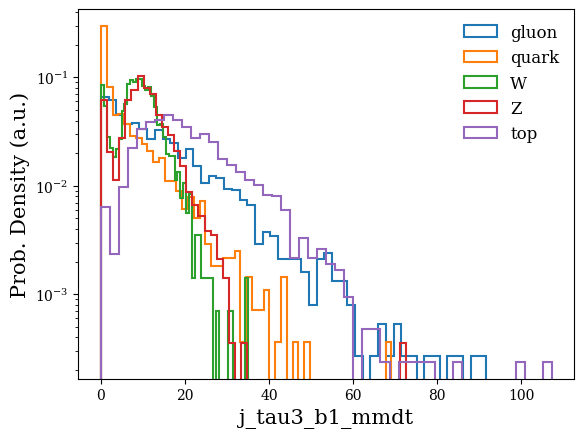

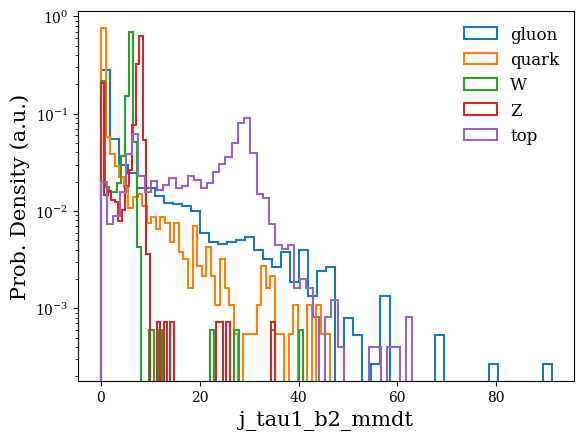

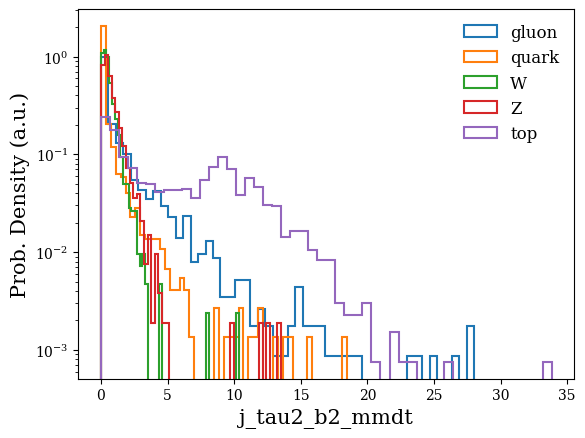

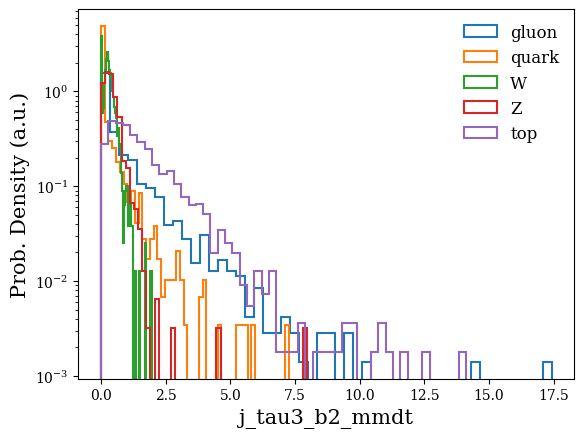

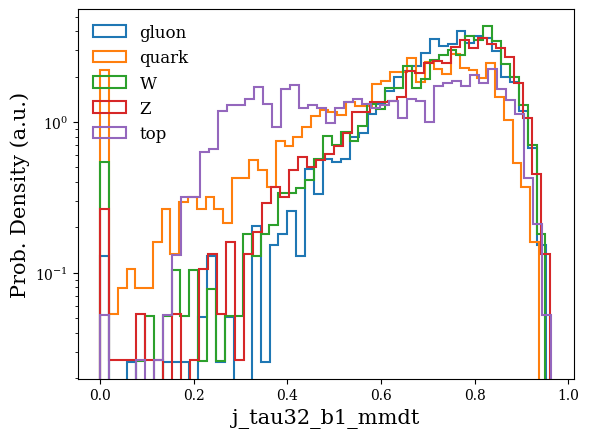

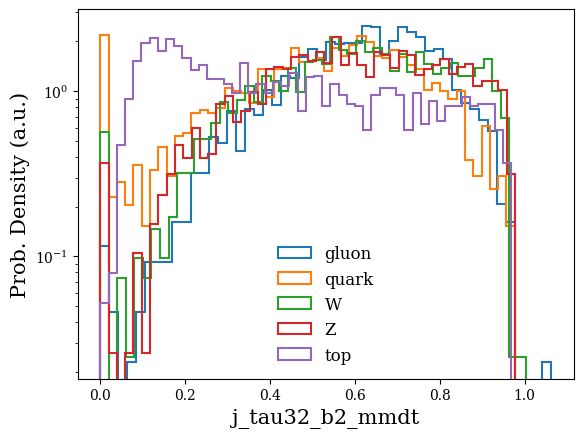

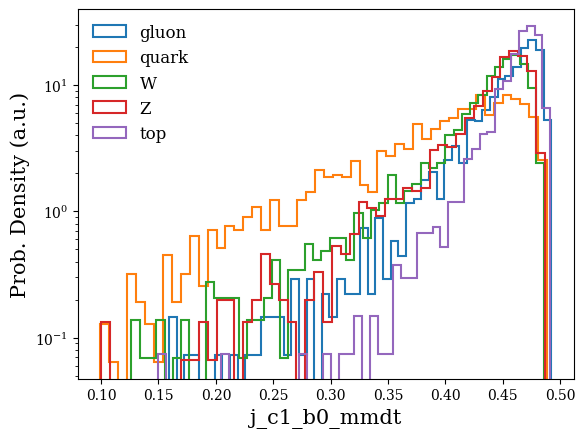

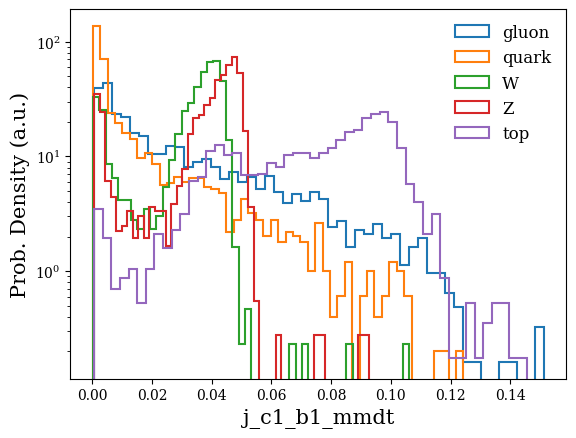

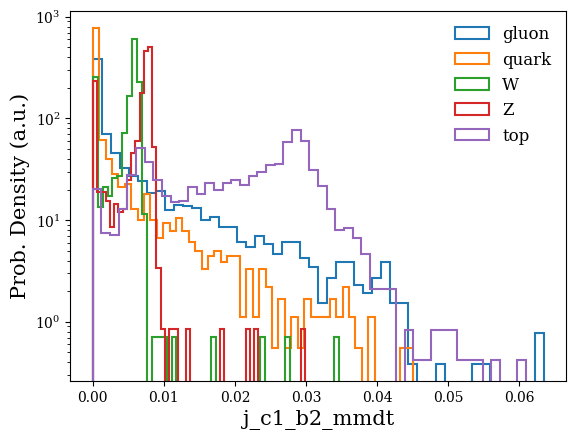

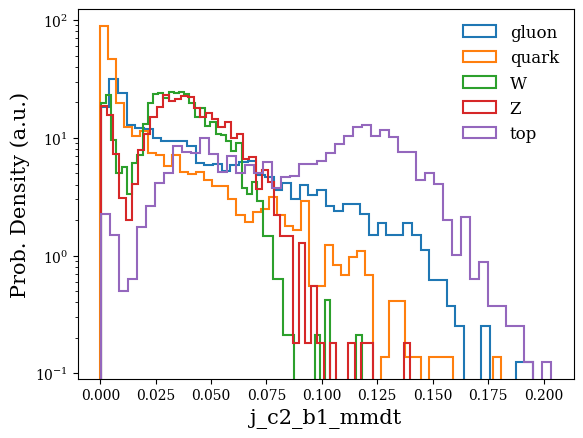

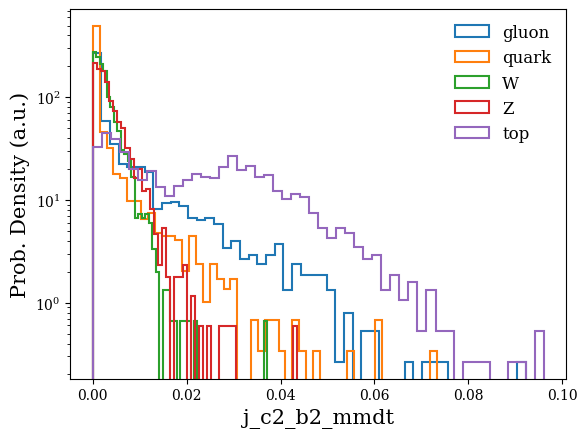

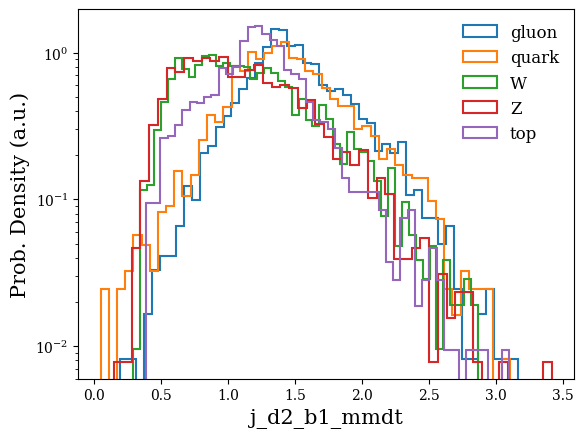

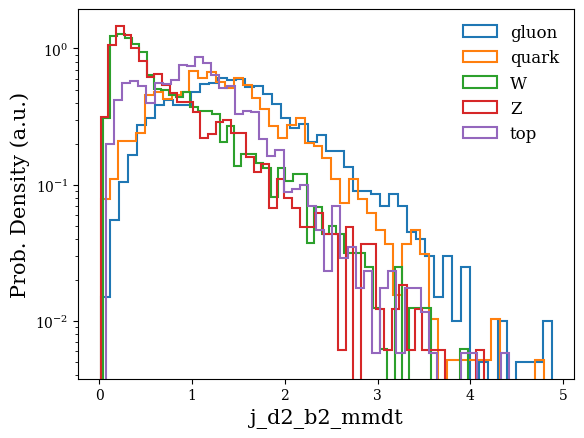

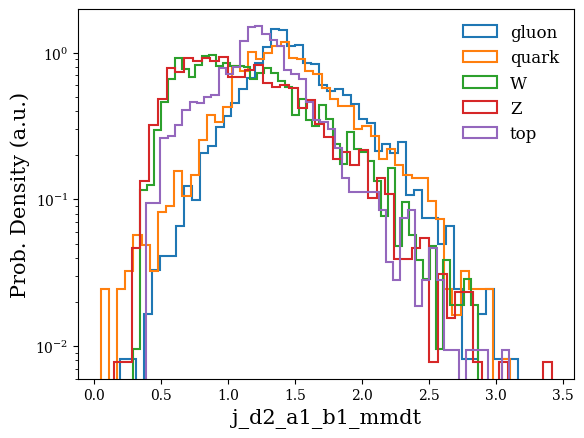

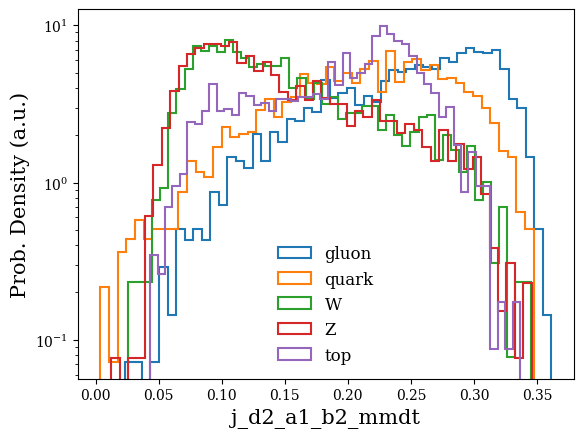

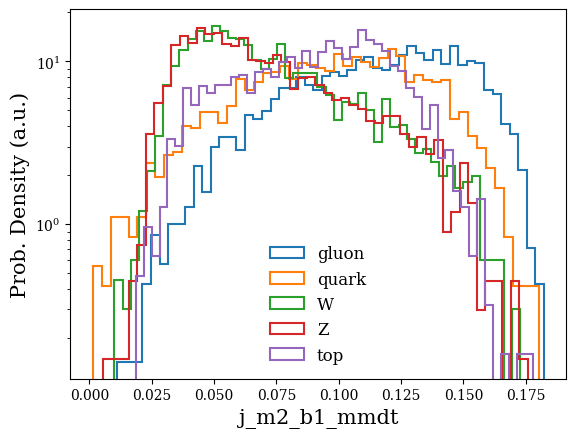

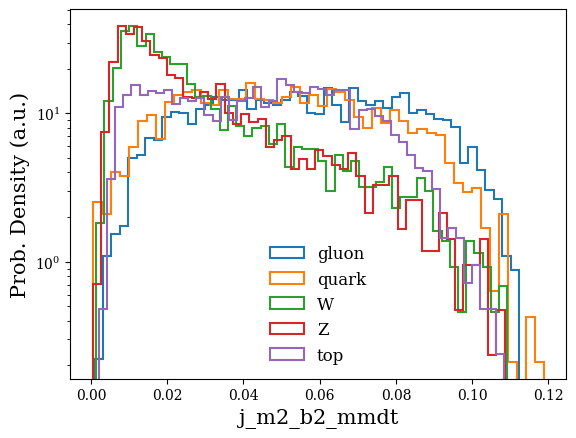

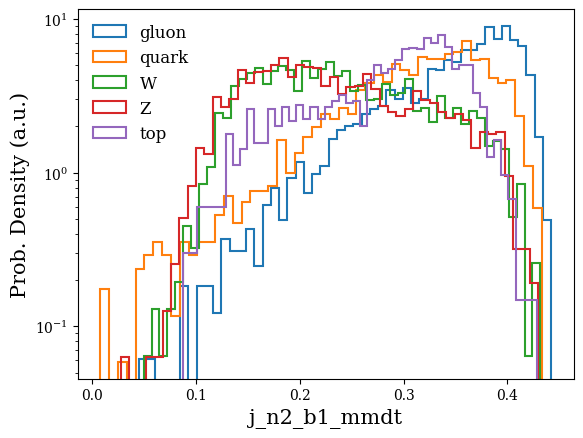

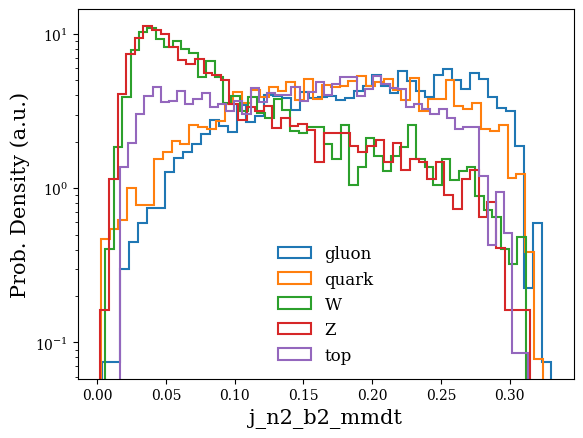

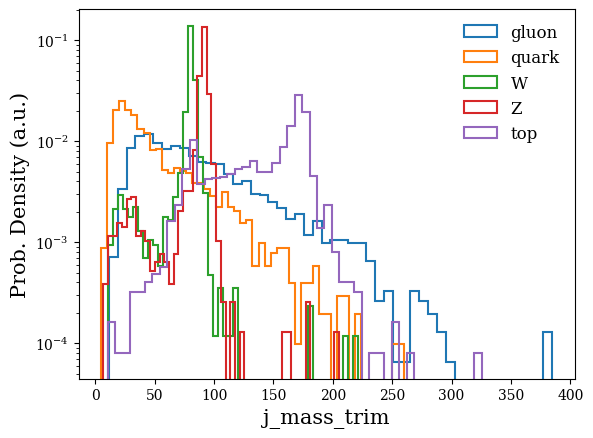

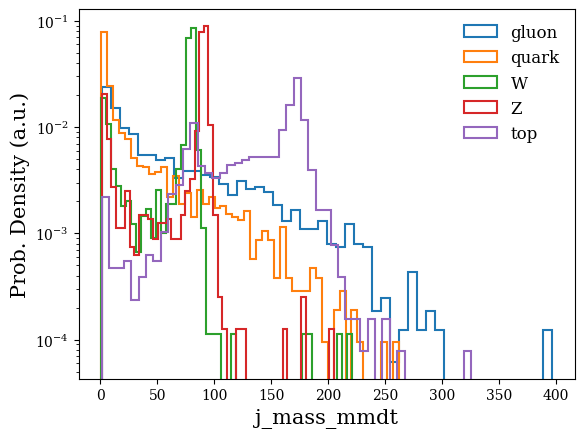

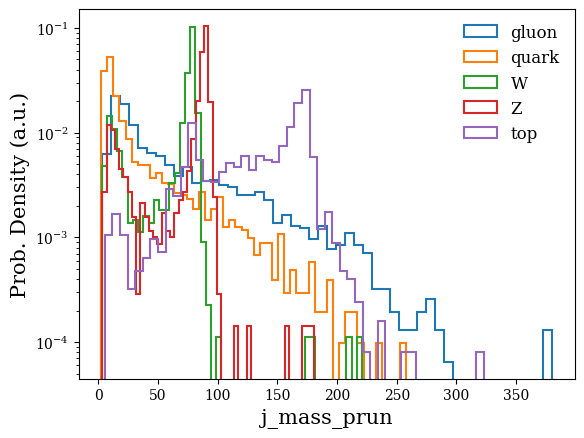

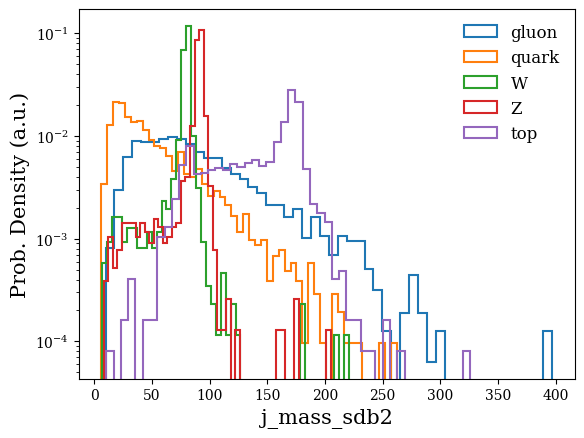

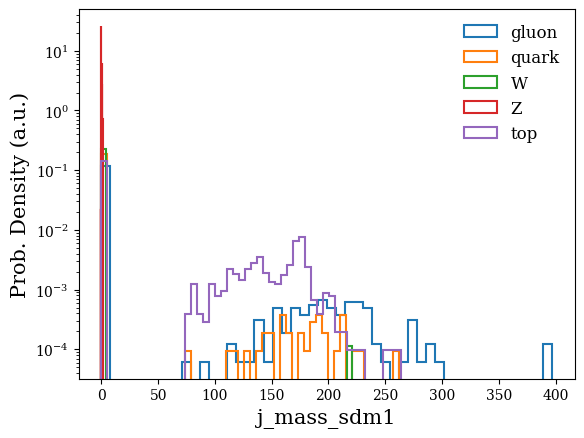

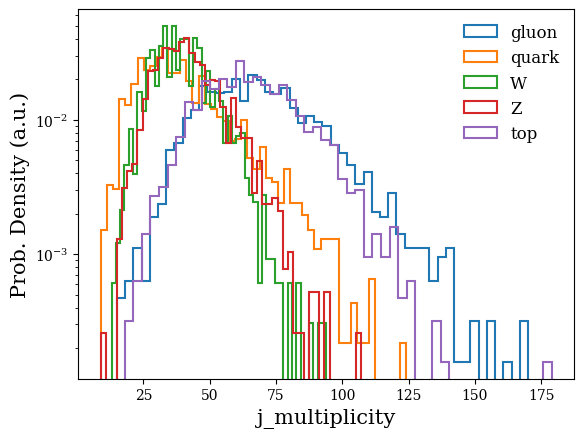

In [27]:
# we now plot all the features
for i in range(len(featurenames[:-6])):
    makePlot(i, data, featurenames)
    #fig.show()

More information on these quantities can be found in https://arxiv.org/pdf/1709.08705.pdf

---

# The image dataset

Jets can be converted to images considering the (&eta;, &phi;) plane, centered along the axis direction and binned.
In our case, we consider a square of 1.6x1.6 in size (because the jet size is R=0.8) binned in 100x100 equal-size 'cells'

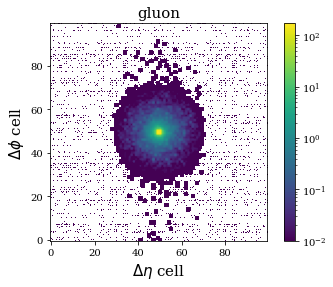

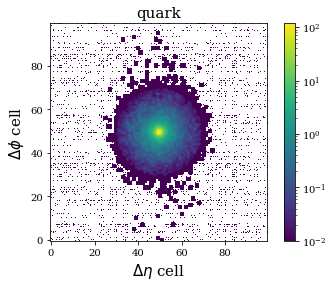

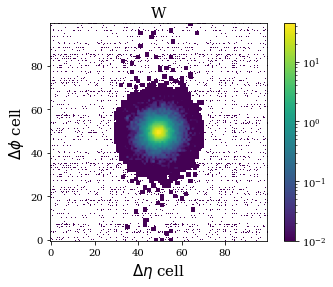

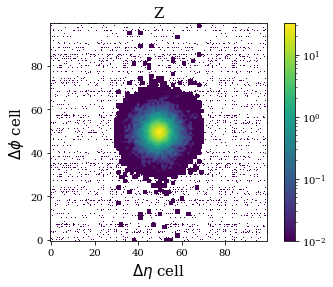

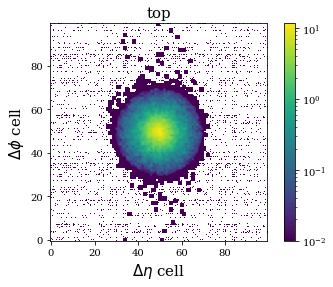

In [9]:
from matplotlib.colors import LogNorm
labelCat= ["gluon", "quark", "W", "Z", "top"]
image = np.array(f.get('jetImage'))
image_g = image[np.argmax(target, axis=1) == 0]
image_q = image[np.argmax(target, axis=1) == 1]
image_W = image[np.argmax(target, axis=1) == 2]
image_Z = image[np.argmax(target, axis=1) == 3]
image_t = image[np.argmax(target, axis=1) == 4]
images = [image_q, image_g, image_W, image_Z, image_t]
# plt.rc('text', usetex=True)
plt.rc('font', family='serif')
for i in range(len(images)):
    SUM_Image = np.sum(images[i], axis = 0)
    plt.imshow(SUM_Image/float(images[i].shape[0]), origin='lower',norm=LogNorm(vmin=0.01))
    plt.colorbar()
    plt.title(labelCat[i], fontsize=15)
    plt.xlabel("$\Delta\eta$ cell", fontsize=15)
    plt.ylabel("$\Delta\phi$ cell", fontsize=15)
    plt.show()


# The particle-list dataset

In this case, we look at the particle-related features that we have stored for each jet constituent. The structure of the dataset is similar to that of the physics-motivated features, except for the fact that we have now a double-index dataset: (jet index, particle index).
The list is cut at XXX constituents /jet. If less are found, the dataset is completed filling it with 0s (zero padding)

In [29]:
p_featurenames = f.get("particleFeatureNames")
print(p_featurenames[:])

[b'j1_px' b'j1_py' b'j1_pz' b'j1_e' b'j1_erel' b'j1_pt' b'j1_ptrel'
 b'j1_eta' b'j1_etarel' b'j1_etarot' b'j1_phi' b'j1_phirel' b'j1_phirot'
 b'j1_deltaR' b'j1_costheta' b'j1_costhetarel' b'j1_pdgid']


In [10]:
p_data = f.get("jetConstituentList")
print(p_data.shape)

(10000, 100, 16)


In [31]:
labelCat= ["gluon", "quark", "W", "Z", "top"]
# this function makes the histogram of a given quantity for the five classes
def makePlot_p(feature_index, input_data, input_featurenames):
    plt.subplots()
    for i in range(len(labelCat)):
        my_data = input_data[:,:,feature_index]
        # notice the use of numpy masking to select specific classes of jets
        my_data = my_data[np.argmax(target, axis=1) == i]
        # then plot the right quantity for the reduced array
        plt.hist(my_data[:,feature_index].flatten(), 50, density=True, histtype='step', fill=False, linewidth=1.5)
    plt.yscale('log')
    plt.legend(labelCat, fontsize=12, frameon=False)
    plt.xlabel(str(input_featurenames[feature_index], "utf-8"), fontsize=15)
    plt.ylabel('Prob. Density (a.u.)', fontsize=15)
    plt.show()
    #del fig, ax
    #return fig, ax

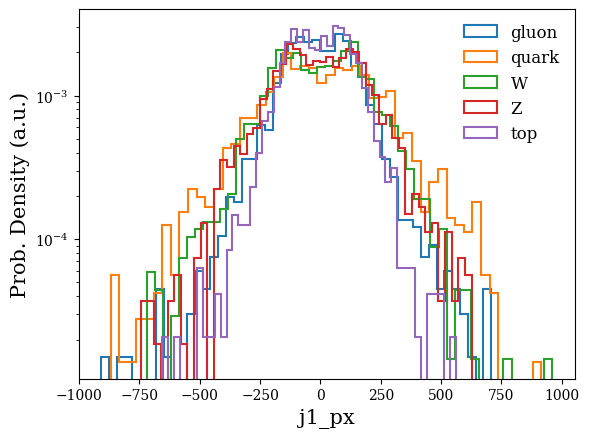

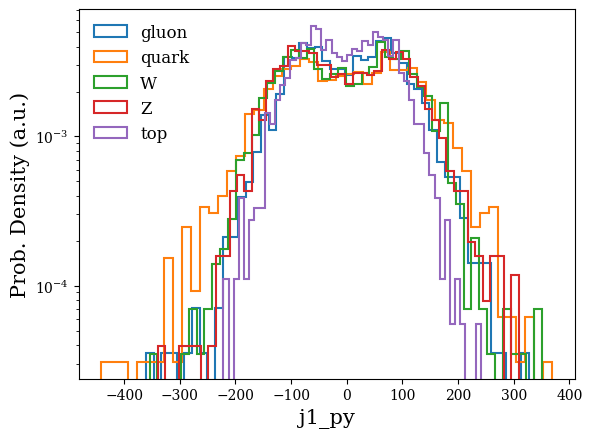

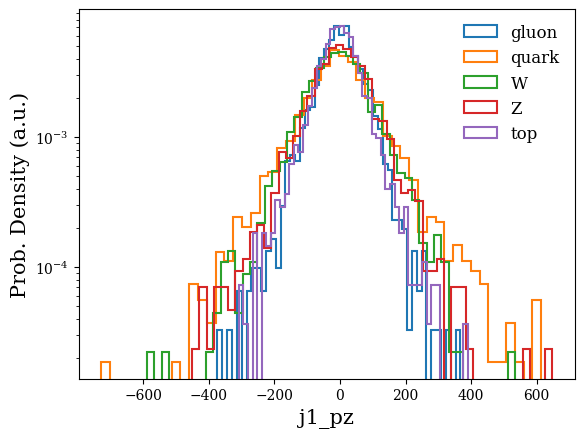

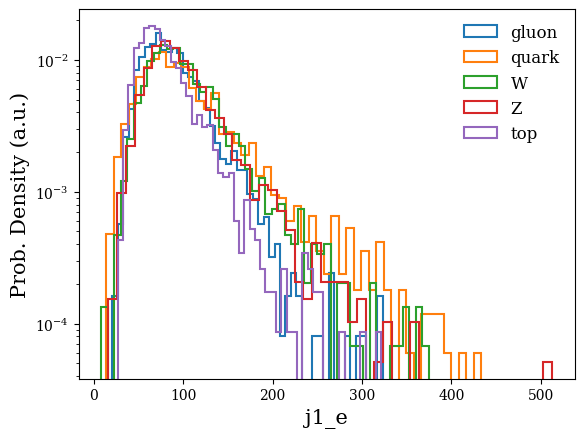

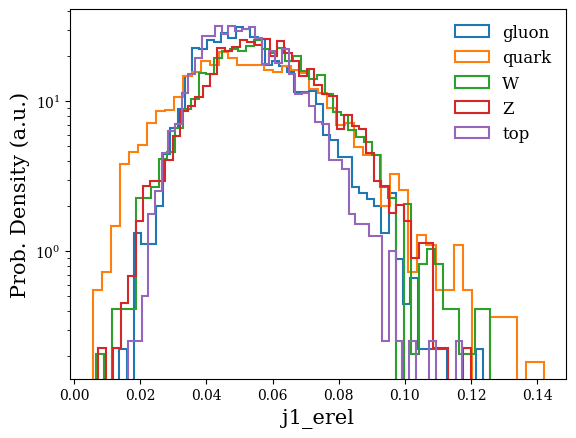

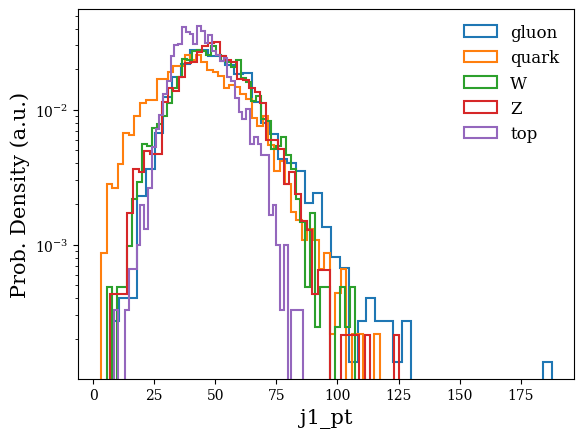

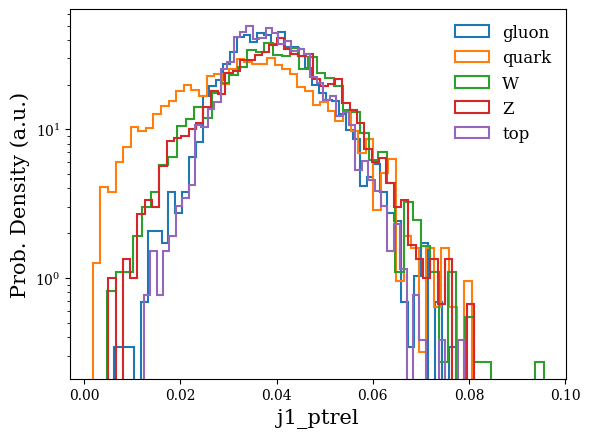

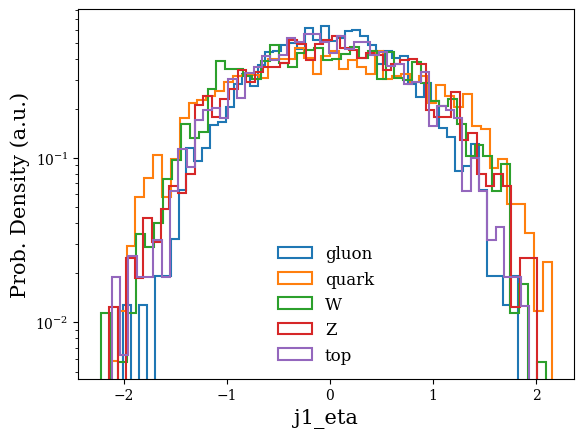

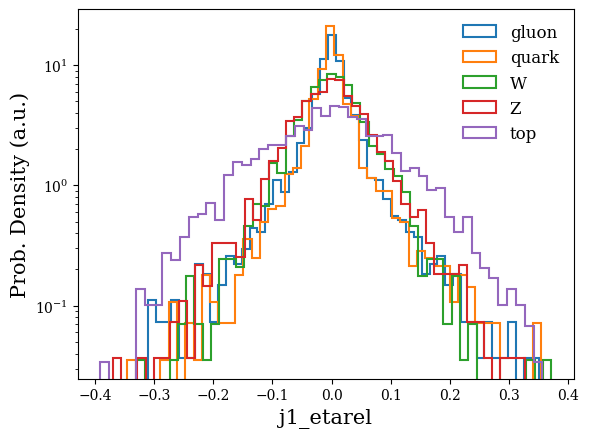

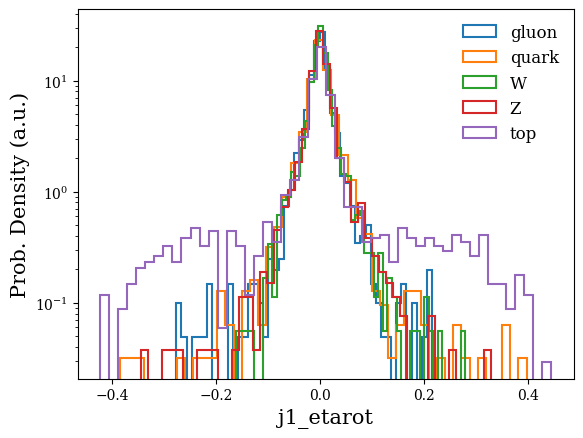

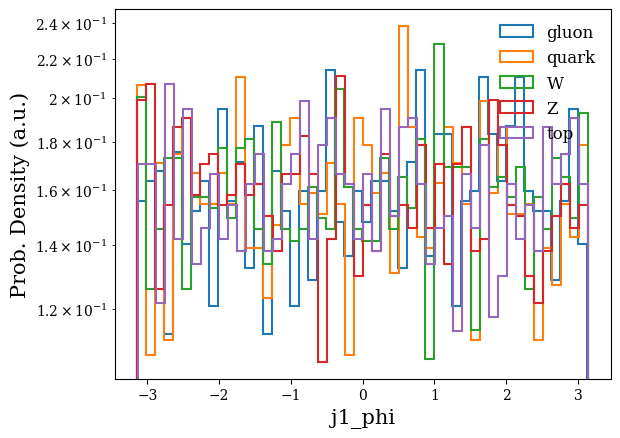

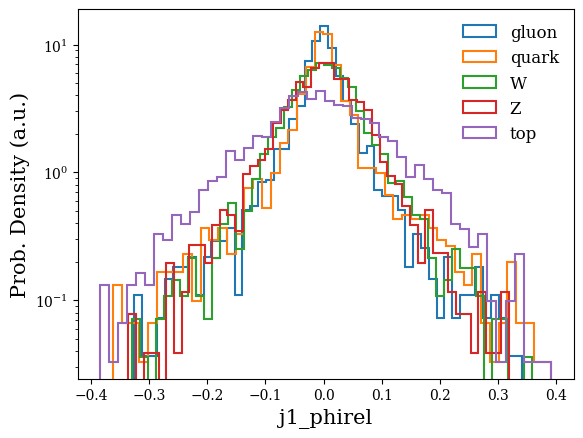

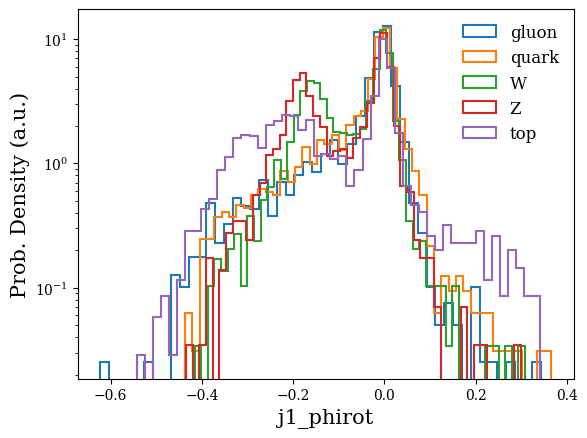

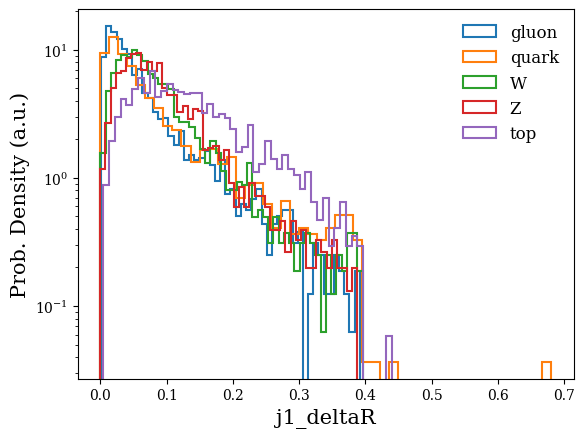

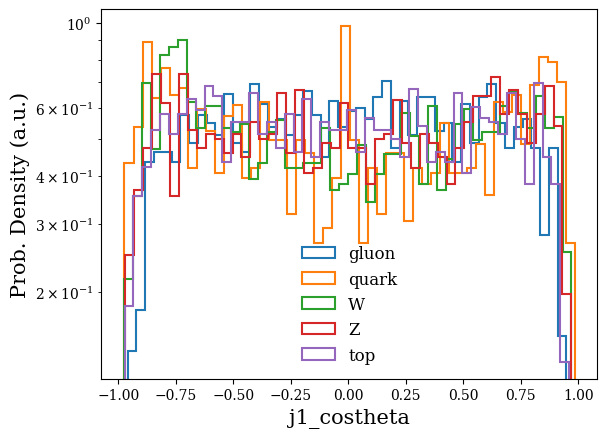

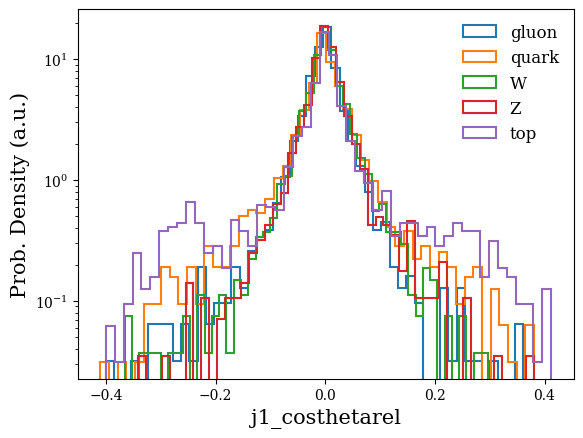

In [32]:
# we now plot all the features
for i in range(len(p_featurenames)-1):
    makePlot_p(i, p_data, p_featurenames)
    #fig.show()